In [13]:
from __future__ import print_function
from scipy.io import arff
from prepare_data import prepare_food
from IPython.display import clear_output

import functools
import numpy as np
import pandas as pd
import sys
from fair_logloss import DP_fair_logloss_classifier, EOPP_fair_logloss_classifier, EODD_fair_logloss_classifier

In [14]:
def compute_error(Yhat,proba,Y):
    err = 1 - np.sum(Yhat == Y) / Y.shape[0] 
    exp_zeroone = np.mean(np.where(Y == 1 , 1 - proba, proba))
    return err, exp_zeroone

In [15]:
def train_and_write_score(criteria, majority, C):
    expected_test_err_list = list()
    fairness_violation_list = list()
    for window in range(19):

        dataA,dataY,dataX = prepare_food(window=window, majority=majority)
        dataset = 'food'

        if criteria == 'dp':
            h = DP_fair_logloss_classifier(C=C, random_initialization=True, verbose=False)
        elif criteria == 'eqopp':
            h = EOPP_fair_logloss_classifier(C=C, random_initialization=True, verbose=False)
        elif criteria == 'eqodd':
            h = EODD_fair_logloss_classifier(C=C, random_initialization=True, verbose=False)    
        else:
            raise ValueError('Invalid second arg')

        tr_idx = dataX.index[dataX['Test'] == False].tolist()
        ts_idx = dataX.index[dataX['Test'] == True].tolist()
        dataX.drop(columns=["Test"], inplace=True)
        tr_X = dataX.reindex(tr_idx)
        ts_X = dataX.reindex(ts_idx)

        tr_A = dataA.reindex(tr_X.index)
        ts_A = dataA.reindex(ts_X.index)
        tr_Y = dataY.reindex(tr_X.index)
        ts_Y = dataY.reindex(ts_X.index)

        if include_A:
            tr_X = pd.concat([tr_X, tr_A], axis=1)
            ts_X = pd.concat([ts_X, ts_A], axis=1)
            dataX = pd.concat([dataX, dataA], axis=1)

        for c in list(tr_X.columns):
            if tr_X[c].min() < 0 or tr_X[c].max() > 1:
                mu = tr_X[c].mean()
                s = tr_X[c].std(ddof=0)
                tr_X.loc[:,c] = (tr_X[c] - mu) / s
                ts_X.loc[:,c] = (ts_X[c] - mu) / s

        h.fit(tr_X.values,tr_Y.values,tr_A.values)
        exp_zo_tr = h.expected_error(tr_X.values, tr_Y.values, tr_A.values)
        exp_zo_ts = h.expected_error(ts_X.values, ts_Y.values, ts_A.values)
        err_tr = 1 - h.score(tr_X.values, tr_Y.values, tr_A.values)
        err_ts = 1 - h.score(ts_X.values, ts_Y.values, ts_A.values)
        violation_tr = h.fairness_violation(tr_X.values, tr_Y.values, tr_A.values)
        violation_ts = h.fairness_violation(ts_X.values, ts_Y.values, ts_A.values)
        
        expected_test_err_list.append(exp_zo_ts)
        fairness_violation_list.append(violation_ts)
        
        print("---------------------------- Random Split: %d ----------------------------------" % window)
        print("Train - predict_err : {:.3f} \t expected_err : {:.3f} \t fair_violation : {:.3f} ".format(err_tr, exp_zo_tr,violation_tr))
        print("Test  - predict_err : {:.3f} \t expected_err : {:.3f} \t fair_violation : {:.3f} ".format(err_ts, exp_zo_ts,violation_ts))
        print("")
        predicted_scores = h.predict_proba(dataX.values, dataA.values)

        np.savetxt(f"./results/scores_{window}_{criteria}_{majority}_{C}.csv", predicted_scores, delimiter=",")
    d = {"expected test error": expected_test_err_list, "fair violation": fairness_violation_list}
    return pd.DataFrame(data=d)

In [16]:
# sanitarian_color = "blue"  # "blue", "brown", "green", "orange", "purple", "yellow"
criteria_list = ["dp","eqopp"]  # "dp","eqopp","eqodd"
majority_list = ["san_maj"] # "san_maj","race_maj","loc_maj"
C_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
include_A = [False]

df_dict = dict()

for criteria in criteria_list:
    for majority in majority_list:
        for C in C_list:
            clear_output(wait=True)
            print(criteria, majority, C)
            df = train_and_write_score(criteria, majority, C)
            df_dict[f"{criteria}_{majority}_{C}"] = df

eqopp san_maj 0.5
---------------------------- Random Split: 0 ----------------------------------
Train - predict_err : 0.141 	 expected_err : 0.380 	 fair_violation : 0.000 
Test  - predict_err : 0.158 	 expected_err : 0.387 	 fair_violation : 0.001 

---------------------------- Random Split: 1 ----------------------------------
Train - predict_err : 0.142 	 expected_err : 0.379 	 fair_violation : 0.000 
Test  - predict_err : nan 	 expected_err : nan 	 fair_violation : nan 

---------------------------- Random Split: 2 ----------------------------------
Train - predict_err : 0.142 	 expected_err : 0.380 	 fair_violation : 0.000 
Test  - predict_err : nan 	 expected_err : nan 	 fair_violation : nan 

---------------------------- Random Split: 3 ----------------------------------
Train - predict_err : 0.140 	 expected_err : 0.378 	 fair_violation : 0.000 
Test  - predict_err : 0.185 	 expected_err : 0.393 	 fair_violation : 0.000 

---------------------------- Random Split: 4 ---------

In [50]:
from collections import defaultdict

stats_dict = defaultdict(lambda: dict())

for key, val in df_dict.items():
    err_stats = dict()
    err_stats['mean'] = val["expected test error"].mean(skipna=True)
    err_stats['stderr'] = val["expected test error"].sem(skipna=True)
    
    fair_stats = dict()
    fair_stats['mean'] = val["fair violation"].mean(skipna=True)
    fair_stats['stderr'] = val["fair violation"].sem(skipna=True)

    stats_dict[key]['err_stats'] = err_stats
    stats_dict[key]['fair_stats'] = fair_stats

In [51]:
dict(stats_dict)

{'dp_san_maj_0.001': {'err_stats': {'mean': 0.27546058320648265,
   'stderr': 0.006069441675317801},
  'fair_stats': {'mean': 0.007941602399467246,
   'stderr': 0.0015409389970712705}},
 'dp_san_maj_0.005': {'err_stats': {'mean': 0.2796845353952941,
   'stderr': 0.004746255844692878},
  'fair_stats': {'mean': 0.006526432107955042,
   'stderr': 0.0013272671804977776}},
 'dp_san_maj_0.01': {'err_stats': {'mean': 0.28173704261542043,
   'stderr': 0.0052783076105367786},
  'fair_stats': {'mean': 0.007190004746115384,
   'stderr': 0.0012998740182790453}},
 'dp_san_maj_0.05': {'err_stats': {'mean': 0.30252291228032596,
   'stderr': 0.003749456169735951},
  'fair_stats': {'mean': 0.0041682078119871435,
   'stderr': 0.000707011767137094}},
 'dp_san_maj_0.1': {'err_stats': {'mean': 0.31377427047506484,
   'stderr': 0.0033507771382810404},
  'fair_stats': {'mean': 0.002585450409823827,
   'stderr': 0.000510132844456068}},
 'dp_san_maj_0.2': {'err_stats': {'mean': 0.3360631466721985,
   'stderr':

In [52]:
# np.where(ts_Y.values == 1), np.where(ts_A.values == 1)

## Plot the performace

In [104]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [105]:
dp_eqopp_arr = np.zeros((2, int(len(stats_dict)/2), 2))
dp_eqopp_err_arr = np.zeros((2, int(len(stats_dict)/2), 2))

idx = 0
for criteria in criteria_list:
    for majority in majority_list:
        for i in range(len(C_list)):
            C = C_list[i]
            dp_eqopp_arr[idx][i][0] = stats_dict[f"{criteria}_{majority}_{C}"]["err_stats"]["mean"]
            dp_eqopp_arr[idx][i][1] = stats_dict[f"{criteria}_{majority}_{C}"]["fair_stats"]["mean"]
            
            dp_eqopp_err_arr[idx][i][0] = stats_dict[f"{criteria}_{majority}_{C}"]["err_stats"]["stderr"]
            dp_eqopp_err_arr[idx][i][1] = stats_dict[f"{criteria}_{majority}_{C}"]["fair_stats"]["stderr"]
            print(f"{criteria}_{majority}_{C}")
    print(idx)
    idx += 1

dp_san_maj_0.001
dp_san_maj_0.005
dp_san_maj_0.01
dp_san_maj_0.05
dp_san_maj_0.1
dp_san_maj_0.2
dp_san_maj_0.3
dp_san_maj_0.4
dp_san_maj_0.5
0
eqopp_san_maj_0.001
eqopp_san_maj_0.005
eqopp_san_maj_0.01
eqopp_san_maj_0.05
eqopp_san_maj_0.1
eqopp_san_maj_0.2
eqopp_san_maj_0.3
eqopp_san_maj_0.4
eqopp_san_maj_0.5
1


In [106]:
dp_eqopp_arr

array([[[0.27546058, 0.0079416 ],
        [0.27968454, 0.00652643],
        [0.28173704, 0.00719   ],
        [0.30252291, 0.00416821],
        [0.31377427, 0.00258545],
        [0.33606315, 0.00287224],
        [0.36152404, 0.00204158],
        [0.37751674, 0.00218764],
        [0.3963292 , 0.00194053]],

       [[0.23105227, 0.14809542],
        [0.23946613, 0.1280168 ],
        [0.24662775, 0.10999112],
        [0.27873906, 0.04886188],
        [0.30097873, 0.02516522],
        [0.33228238, 0.00690358],
        [0.35286496, 0.00318362],
        [0.36742616, 0.00280564],
        [0.37895612, 0.00228453]]])

In [107]:
dp_eqopp_err_arr[0,:,1]

array([0.00154094, 0.00132727, 0.00129987, 0.00070701, 0.00051013,
       0.00051553, 0.00031809, 0.0003607 , 0.00028093])

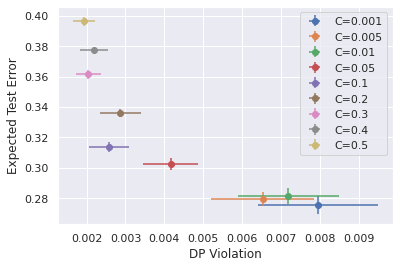

In [112]:
fig, ax = plt.subplots()
for i in range(dp_eqopp_arr.shape[1]):
    ax.errorbar(dp_eqopp_arr[0,i,1], dp_eqopp_arr[0,i,0], xerr=dp_eqopp_err_arr[0,i,1], yerr=dp_eqopp_err_arr[0,i,0], fmt="o", 
                label=f"C={C_list[i]}")
ax.set_ylabel('Expected Test Error')
ax.set_xlabel('DP Violation')
ax.legend()
plt.savefig(f"dp_violation.pdf", bbox_inches='tight', dpi=300)

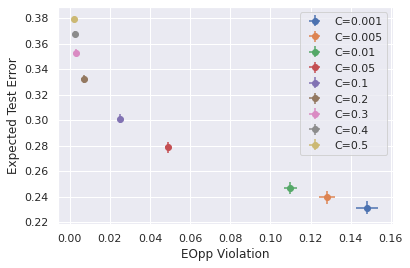

In [113]:
fig, ax = plt.subplots()
for i in range(dp_eqopp_arr.shape[1]):
    ax.errorbar(dp_eqopp_arr[1,i,1], dp_eqopp_arr[1,i,0], xerr=dp_eqopp_err_arr[1,i,1], yerr=dp_eqopp_err_arr[1,i,0], fmt="o", 
                label=f"C={C_list[i]}")
ax.set_ylabel('Expected Test Error')
ax.set_xlabel('EOpp Violation')
ax.legend()
plt.savefig(f"eopp_violation.pdf", bbox_inches='tight', dpi=300)